In [1]:
import h5py, os
import numpy as np
from tqdm import tqdm

from msfm.utils import files, observation, cross_statistics, power_spectra
from deep_lss.utils import configuration
from msi.utils import preprocessing, plotting

# find sobol indices closest to Buzzard cosmology

In [2]:
meta_file = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/data/CosmoGridV1_metainfo.h5"
with h5py.File(meta_file, "r") as f:
    print(f.keys())
    print(f["parameters"].keys())

    grid_params = f["parameters/grid"][:]

<KeysViewHDF5 ['parameters', 'shell_info', 'simulations']>
<KeysViewHDF5 ['all', 'benchmark', 'fiducial', 'grid']>


In [3]:
buzzard_cosmo = np.array([0.286, 0.82, -1]) # h = 0.7, ns = 0.96, Omega_b = 0.046 
i_sobols = grid_params["sobol_index"]

cosmo_params = ["Om", "s8", "w0"]
grid_cosmo = np.stack([grid_params[param] for param in cosmo_params], axis=-1)

param_min = grid_cosmo.min(axis=0)
param_max = grid_cosmo.max(axis=0)
grid_cosmo_normalized = (grid_cosmo - param_min) / (param_max - param_min)

buzzard_cosmo_normalized = (buzzard_cosmo - param_min) / (param_max - param_min)

In [4]:
# distances = np.linalg.norm(grid_cosmo_normalized - buzzard_cosmo_normalized, axis=1)
distances = np.linalg.norm(grid_cosmo - buzzard_cosmo, axis=1)

n = 5
closest_indices = np.argsort(distances)[:n]
closest_sobols = i_sobols[closest_indices]
closest_points = grid_cosmo[closest_indices]

print("closest", n, "points:\n", closest_points)
print("distances", distances[closest_indices])
print("indices:", closest_indices)
print("i_sobols:", closest_sobols)

closest 5 points:
 [[ 0.28362122  0.83476105 -1.0074589 ]
 [ 0.30283051  0.83092728 -0.99843534]
 [ 0.27389526  0.8223175  -0.9670023 ]
 [ 0.26190033  0.84841385 -0.99930017]
 [ 0.28247681  0.81880798 -0.96094844]]
distances [0.01670875 0.02012758 0.03522419 0.03726434 0.03922828]
indices: [1954 2307 1483 2380 1585]
i_sobols: [114996 172798  40100 184644  57908]


In [5]:
print(grid_params["ns"][closest_indices])
print(grid_params["Ob"][closest_indices])
print(grid_params["H0"][closest_indices])

[0.98624603 0.99486038 0.97454407 0.97588455 0.9475238 ]
[0.04262169 0.04872334 0.04701462 0.04199146 0.04603592]
[65.9026947  65.26734161 68.5887146  68.4275589  73.12661743]


# load Buzzard $C_\ell$ best fit

In [6]:
def get_MAP(obs_label):
    chain = np.load(os.path.join(cls_dir, f"chain_{obs_label}.npy"))
    log_probs = np.load(os.path.join(cls_dir, f"log_probs_{obs_label}.npy"))
    
    MAP_params = chain[np.argmax(log_probs)]
    MAP_dict = {p: np.round(v, 3) for p, v in zip(params, MAP_params)}

    return [MAP_dict[bg] for bg in bgs]

def get_MAP_constrained(obs_label, fixed_cosmo_params, tolerance=1e-2):
    chain = np.load(os.path.join(cls_dir, f"chain_{obs_label}.npy"))
    log_probs = np.load(os.path.join(cls_dir, f"log_probs_{obs_label}.npy"))

    n_cosmo_params = len(fixed_cosmo_params)
    mask = np.ones(len(chain), dtype=bool)
    for i in range(n_cosmo_params):
        mask &= (np.abs(chain[:, i] - fixed_cosmo_params[i]) < tolerance)
    
    if not np.any(mask):
        raise ValueError("No samples match the fixed parameters within tolerance")

    print(f"{np.sum(mask)} values within the tolerance for the fixed Om, s8, w0")
    
    filtered_chain = chain[mask]
    filtered_log_probs = log_probs[mask]
    best_idx = np.argmax(filtered_log_probs)
    
    return filtered_chain[best_idx][n_cosmo_params:]


In [7]:
cls_dir =  "/pscratch/sd/a/athomsen/run_files/v14/cls/lensing=False,clustering=True,standard=False,log=True,cosine=False,steps=400000/32mpc_sigmoid/likelihood_flow"
params = ["Om", "s8", "w0", "bg1", "bg2", "bg3", "bg4"]
bgs = [f"bg{i}" for i in range(1,5)]

buzzard_indices = list(range(0, 16))
buzzard_indices.remove(1)
tomo_bg_single_buzzard = []
for i in buzzard_indices:
    # tomo_bg_single_buzzard.append(get_MAP(f"Buzzard_{i}"))
    tomo_bg_single_buzzard.append(get_MAP_constrained(f"Buzzard_{i}", buzzard_cosmo))

tomo_bg_buzzard_flock = np.stack(tomo_bg_single_buzzard, axis=0)
print(tomo_bg_buzzard_flock)

95 values within the tolerance for the fixed Om, s8, w0
263 values within the tolerance for the fixed Om, s8, w0
212 values within the tolerance for the fixed Om, s8, w0
259 values within the tolerance for the fixed Om, s8, w0
87 values within the tolerance for the fixed Om, s8, w0
285 values within the tolerance for the fixed Om, s8, w0
23 values within the tolerance for the fixed Om, s8, w0
215 values within the tolerance for the fixed Om, s8, w0
95 values within the tolerance for the fixed Om, s8, w0
98 values within the tolerance for the fixed Om, s8, w0
94 values within the tolerance for the fixed Om, s8, w0
237 values within the tolerance for the fixed Om, s8, w0
66 values within the tolerance for the fixed Om, s8, w0
163 values within the tolerance for the fixed Om, s8, w0
186 values within the tolerance for the fixed Om, s8, w0
[[1.44650523 1.6171896  1.75748009 1.76448134]
 [1.40585707 1.6258683  1.68139063 1.82052375]
 [1.3758552  1.59328849 1.68389322 1.75261556]
 [1.3867784

In [8]:
# tomo_bg_buzzard_mean = get_MAP("Buzzard_mean")
tomo_bg_buzzard_mean = get_MAP_constrained("Buzzard_mean", buzzard_cosmo)
print(tomo_bg_buzzard_mean)

342 values within the tolerance for the fixed Om, s8, w0
[1.39202429 1.58696377 1.70599124 1.76836719]


In [9]:
# tomo_bg_buzzard_stack = get_MAP("Buzzard_stack")
tomo_bg_buzzard_stack = get_MAP_constrained("Buzzard_stack", buzzard_cosmo)
print(tomo_bg_buzzard_stack)

14 values within the tolerance for the fixed Om, s8, w0
[1.41911453 1.61798366 1.72372091 1.7602665 ]


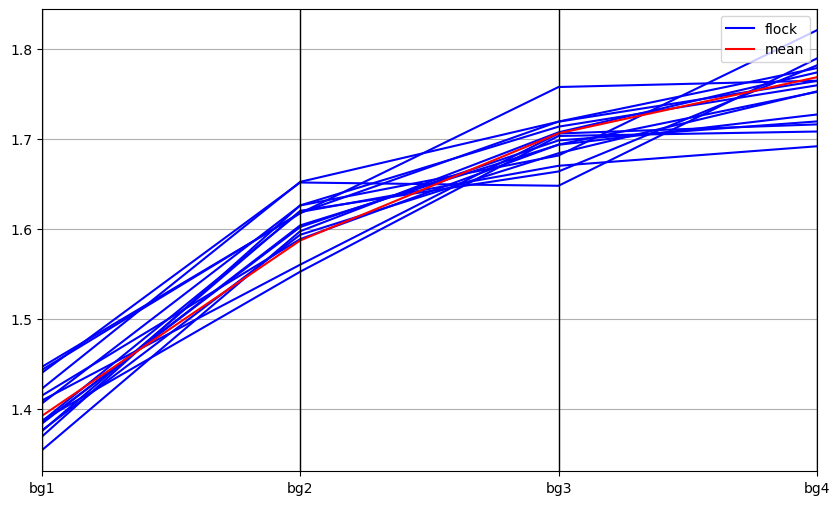

In [10]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

df = pd.DataFrame(tomo_bg_buzzard_flock, columns=bgs)
df['label'] = 'flock'
point_df = pd.DataFrame([tomo_bg_buzzard_mean], columns=bgs)
point_df['label'] = 'mean'
full_df = pd.concat([df, point_df], ignore_index=True)

plt.figure(figsize=(10, 6))
parallel_coordinates(full_df, 'label', color=['blue', 'red'])
plt.grid(True)
plt.show()

In [11]:
# tomo_bg_buzzard = tomo_bg_buzzard_mean
# i_buzzard = 1
# i_buzzard = 3
# tomo_bg_buzzard = tomo_bg_buzzard_flock[i_buzzard]
# tomo_bg_buzzard = [2.5]*4

tomo_bg_buzzard = tomo_bg_buzzard_mean
# tomo_bg_buzzard = tomo_bg_buzzard_stack

print(tomo_bg_buzzard)

[1.39202429 1.58696377 1.70599124 1.76836719]


# forward model maps according to Buzzard $C_\ell$ best fit

In [12]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")
label = "8,32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/combined/dlss_{label}.yaml"
)
cosmogrid_dir = "/global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid"
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended"

with_lensing = False
with_clustering = True

25-06-19 00:28:23 configuratio INF   Loaded the config 


In [13]:
closest_sobol = closest_sobols[0]
cosmo_dir = os.path.join(cosmogrid_dir, f"cosmo_{closest_sobol:06d}")

cosmogrid_cls = []
for i in tqdm(range(20)):
    perm_dir = os.path.join(cosmo_dir, f"perm_{i:04d}")

    wl_gamma_patch, gc_count_patch = observation.forward_model_cosmogrid(
        perm_dir,
        conf=msfm_conf,
        noisy=True,
        # lensing
        with_lensing=with_lensing,
        tomo_Aia=None,
        bta=None,
        i_sobol=closest_sobol,
        # clustering
        with_clustering=with_clustering,
        tomo_bg=tomo_bg_buzzard,
        noise_seed=12,
    )

    obs_map, obs_cls_raw, footprint_pix = observation.forward_model_observation_map(
        wl_gamma_map=wl_gamma_patch,
        gc_count_map=gc_count_patch,
        conf=msfm_conf,
        # apply_norm=True,
        apply_norm=False,
        with_padding=True,
        nest_in=False,
    )

    if not (with_lensing and with_clustering):
        obs_cls_full = np.zeros((obs_cls_raw.shape[0], 36))

        bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
            with_lensing=with_lensing,
            with_clustering=with_clustering,
            with_cross_z=True,
        )
        
        obs_cls_full[:,bin_indices] = obs_cls_raw

    obs_cls = preprocessing.get_preprocessed_cl_observation(
        obs_cl=obs_cls_full,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        # selection
        with_lensing=with_lensing,
        with_clustering=with_clustering,
        with_cross_z=True,
        with_cross_probe=(with_lensing and with_clustering),
        # additional preprocessing
        apply_log=False,
        standardize=False,
        # plotting
        make_plot=False,
    )

    cosmogrid_cls.append(obs_cls)

cosmogrid_cls = np.concatenate(cosmogrid_cls, axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

25-06-19 00:28:24 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0000/projected_probes_maps_v11dmb.h5 
25-06-19 00:28:24 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:29:08 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:29:08 observation. INF   No quadratic biasing 
25-06-19 00:29:08 observation. INF   Finished galaxy clustering after 0:00:44.82 
25-06-19 00:29:12 configuratio INF   Loaded the config 
25-06-19 00:29:12 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:29:12 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:29:12 preprocessin INF   Adding white noise to the observation 
25-06-19 00:29:12 preprocessin INF   Using the bin indic

  5%|▌         | 1/20 [00:48<15:24, 48.68s/it]

25-06-19 00:29:12 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0001/projected_probes_maps_v11dmb.h5 
25-06-19 00:29:12 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:29:57 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:29:57 observation. INF   No quadratic biasing 
25-06-19 00:29:57 observation. INF   Finished galaxy clustering after 0:00:44.95 
25-06-19 00:30:00 configuratio INF   Loaded the config 
25-06-19 00:30:00 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:30:00 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:30:00 preprocessin INF   Adding white noise to the observation 
25-06-19 00:30:00 preprocessin INF   Using the bin indic

 10%|█         | 2/20 [01:36<14:29, 48.32s/it]

25-06-19 00:30:00 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0002/projected_probes_maps_v11dmb.h5 
25-06-19 00:30:00 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:30:45 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:30:45 observation. INF   No quadratic biasing 
25-06-19 00:30:45 observation. INF   Finished galaxy clustering after 0:00:44.94 
25-06-19 00:30:48 configuratio INF   Loaded the config 
25-06-19 00:30:48 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:30:48 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:30:48 preprocessin INF   Adding white noise to the observation 
25-06-19 00:30:48 preprocessin INF   Using the bin indic

 15%|█▌        | 3/20 [02:24<13:38, 48.16s/it]

25-06-19 00:30:48 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0003/projected_probes_maps_v11dmb.h5 
25-06-19 00:30:48 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:31:33 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:31:33 observation. INF   No quadratic biasing 
25-06-19 00:31:33 observation. INF   Finished galaxy clustering after 0:00:44.91 
25-06-19 00:31:36 configuratio INF   Loaded the config 
25-06-19 00:31:36 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:31:36 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:31:36 preprocessin INF   Adding white noise to the observation 
25-06-19 00:31:36 preprocessin INF   Using the bin indic

 20%|██        | 4/20 [03:12<12:50, 48.13s/it]

25-06-19 00:31:36 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0004/projected_probes_maps_v11dmb.h5 
25-06-19 00:31:36 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:32:20 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:32:20 observation. INF   No quadratic biasing 
25-06-19 00:32:21 observation. INF   Finished galaxy clustering after 0:00:44.21 
25-06-19 00:32:23 configuratio INF   Loaded the config 
25-06-19 00:32:23 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:32:23 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:32:23 preprocessin INF   Adding white noise to the observation 
25-06-19 00:32:23 preprocessin INF   Using the bin indic

 25%|██▌       | 5/20 [04:00<11:57, 47.81s/it]

25-06-19 00:32:24 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0005/projected_probes_maps_v11dmb.h5 
25-06-19 00:32:24 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:33:07 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:33:07 observation. INF   No quadratic biasing 
25-06-19 00:33:07 observation. INF   Finished galaxy clustering after 0:00:43.58 
25-06-19 00:33:10 configuratio INF   Loaded the config 
25-06-19 00:33:10 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:33:10 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:33:10 preprocessin INF   Adding white noise to the observation 
25-06-19 00:33:10 preprocessin INF   Using the bin indic

 30%|███       | 6/20 [04:46<11:03, 47.41s/it]

25-06-19 00:33:10 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0006/projected_probes_maps_v11dmb.h5 
25-06-19 00:33:10 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:33:55 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:33:55 observation. INF   No quadratic biasing 
25-06-19 00:33:55 observation. INF   Finished galaxy clustering after 0:00:45.20 
25-06-19 00:33:58 configuratio INF   Loaded the config 
25-06-19 00:33:58 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:33:58 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:33:58 preprocessin INF   Adding white noise to the observation 
25-06-19 00:33:58 preprocessin INF   Using the bin indic

 35%|███▌      | 7/20 [05:34<10:20, 47.70s/it]

25-06-19 00:33:58 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0007/projected_probes_maps_v11dmb.h5 
25-06-19 00:33:59 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:34:54 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:34:54 observation. INF   No quadratic biasing 
25-06-19 00:34:54 observation. INF   Finished galaxy clustering after 0:00:55.90 
25-06-19 00:34:57 configuratio INF   Loaded the config 
25-06-19 00:34:57 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:34:57 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:34:57 preprocessin INF   Adding white noise to the observation 
25-06-19 00:34:57 preprocessin INF   Using the bin indic

 40%|████      | 8/20 [06:33<10:15, 51.31s/it]

25-06-19 00:34:58 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0008/projected_probes_maps_v11dmb.h5 
25-06-19 00:34:58 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:35:41 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:35:41 observation. INF   No quadratic biasing 
25-06-19 00:35:41 observation. INF   Finished galaxy clustering after 0:00:43.74 
25-06-19 00:35:44 configuratio INF   Loaded the config 
25-06-19 00:35:44 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:35:44 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:35:44 preprocessin INF   Adding white noise to the observation 
25-06-19 00:35:44 preprocessin INF   Using the bin indic

 45%|████▌     | 9/20 [07:20<09:08, 49.89s/it]

25-06-19 00:35:44 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0009/projected_probes_maps_v11dmb.h5 
25-06-19 00:35:44 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:36:31 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:36:31 observation. INF   No quadratic biasing 
25-06-19 00:36:31 observation. INF   Finished galaxy clustering after 0:00:47.07 
25-06-19 00:36:34 configuratio INF   Loaded the config 
25-06-19 00:36:34 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:36:34 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:36:34 preprocessin INF   Adding white noise to the observation 
25-06-19 00:36:34 preprocessin INF   Using the bin indic

 50%|█████     | 10/20 [08:10<08:19, 49.98s/it]

25-06-19 00:36:34 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0010/projected_probes_maps_v11dmb.h5 
25-06-19 00:36:35 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:37:24 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:37:24 observation. INF   No quadratic biasing 
25-06-19 00:37:24 observation. INF   Finished galaxy clustering after 0:00:49.78 
25-06-19 00:37:27 configuratio INF   Loaded the config 
25-06-19 00:37:27 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:37:27 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:37:27 preprocessin INF   Adding white noise to the observation 
25-06-19 00:37:27 preprocessin INF   Using the bin indic

 55%|█████▌    | 11/20 [09:03<07:37, 50.87s/it]

25-06-19 00:37:27 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0011/projected_probes_maps_v11dmb.h5 
25-06-19 00:37:27 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:38:12 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:38:12 observation. INF   No quadratic biasing 
25-06-19 00:38:13 observation. INF   Finished galaxy clustering after 0:00:45.21 
25-06-19 00:38:15 configuratio INF   Loaded the config 
25-06-19 00:38:15 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:38:15 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:38:16 preprocessin INF   Adding white noise to the observation 
25-06-19 00:38:16 preprocessin INF   Using the bin indic

 60%|██████    | 12/20 [09:52<06:40, 50.08s/it]

25-06-19 00:38:16 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0012/projected_probes_maps_v11dmb.h5 
25-06-19 00:38:16 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:39:02 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:39:02 observation. INF   No quadratic biasing 
25-06-19 00:39:02 observation. INF   Finished galaxy clustering after 0:00:46.28 
25-06-19 00:39:05 configuratio INF   Loaded the config 
25-06-19 00:39:05 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:39:05 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:39:05 preprocessin INF   Adding white noise to the observation 
25-06-19 00:39:05 preprocessin INF   Using the bin indic

 65%|██████▌   | 13/20 [10:41<05:49, 49.87s/it]

25-06-19 00:39:05 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0013/projected_probes_maps_v11dmb.h5 
25-06-19 00:39:05 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:39:47 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:39:47 observation. INF   No quadratic biasing 
25-06-19 00:39:48 observation. INF   Finished galaxy clustering after 0:00:42.57 
25-06-19 00:39:50 configuratio INF   Loaded the config 
25-06-19 00:39:50 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:39:50 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:39:51 preprocessin INF   Adding white noise to the observation 
25-06-19 00:39:51 preprocessin INF   Using the bin indic

 70%|███████   | 14/20 [11:27<04:51, 48.59s/it]

25-06-19 00:39:51 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0014/projected_probes_maps_v11dmb.h5 
25-06-19 00:39:51 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:40:39 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:40:39 observation. INF   No quadratic biasing 
25-06-19 00:40:40 observation. INF   Finished galaxy clustering after 0:00:48.96 
25-06-19 00:40:43 configuratio INF   Loaded the config 
25-06-19 00:40:43 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:40:43 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:40:43 preprocessin INF   Adding white noise to the observation 
25-06-19 00:40:43 preprocessin INF   Using the bin indic

 75%|███████▌  | 15/20 [12:19<04:08, 49.65s/it]

25-06-19 00:40:43 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0015/projected_probes_maps_v11dmb.h5 
25-06-19 00:40:43 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:41:27 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:41:27 observation. INF   No quadratic biasing 
25-06-19 00:41:27 observation. INF   Finished galaxy clustering after 0:00:44.40 
25-06-19 00:41:30 configuratio INF   Loaded the config 
25-06-19 00:41:30 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:41:30 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:41:30 preprocessin INF   Adding white noise to the observation 
25-06-19 00:41:30 preprocessin INF   Using the bin indic

 80%|████████  | 16/20 [13:07<03:16, 49.08s/it]

25-06-19 00:41:31 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0016/projected_probes_maps_v11dmb.h5 
25-06-19 00:41:31 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:42:14 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:42:14 observation. INF   No quadratic biasing 
25-06-19 00:42:15 observation. INF   Finished galaxy clustering after 0:00:44.29 
25-06-19 00:42:18 configuratio INF   Loaded the config 
25-06-19 00:42:18 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:42:18 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:42:18 preprocessin INF   Adding white noise to the observation 
25-06-19 00:42:18 preprocessin INF   Using the bin indic

 85%|████████▌ | 17/20 [13:54<02:25, 48.56s/it]

25-06-19 00:42:18 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0017/projected_probes_maps_v11dmb.h5 
25-06-19 00:42:18 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:43:03 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:43:03 observation. INF   No quadratic biasing 
25-06-19 00:43:04 observation. INF   Finished galaxy clustering after 0:00:45.63 
25-06-19 00:43:06 configuratio INF   Loaded the config 
25-06-19 00:43:06 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:43:06 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:43:06 preprocessin INF   Adding white noise to the observation 
25-06-19 00:43:06 preprocessin INF   Using the bin indic

 90%|█████████ | 18/20 [14:43<01:37, 48.61s/it]

25-06-19 00:43:07 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0018/projected_probes_maps_v11dmb.h5 
25-06-19 00:43:07 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:43:52 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:43:52 observation. INF   No quadratic biasing 
25-06-19 00:43:52 observation. INF   Finished galaxy clustering after 0:00:45.43 
25-06-19 00:43:55 configuratio INF   Loaded the config 
25-06-19 00:43:55 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:43:55 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:43:55 preprocessin INF   Adding white noise to the observation 
25-06-19 00:43:55 preprocessin INF   Using the bin indic

 95%|█████████▌| 19/20 [15:31<00:48, 48.60s/it]

25-06-19 00:43:55 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/grid/cosmo_114996/perm_0019/projected_probes_maps_v11dmb.h5 
25-06-19 00:43:55 observation. INF   Starting with the galaxy clustering map 
25-06-19 00:44:54 observation. INF   Using tomo_bg=[1.39202429 1.58696377 1.70599124 1.76836719] from the function call 
25-06-19 00:44:54 observation. INF   No quadratic biasing 
25-06-19 00:44:55 observation. INF   Finished galaxy clustering after 0:00:59.59 
25-06-19 00:44:58 configuratio INF   Loaded the config 
25-06-19 00:44:58 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-19 00:44:58 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-19 00:44:58 preprocessin INF   Adding white noise to the observation 
25-06-19 00:44:58 preprocessin INF   Using the bin indic

100%|██████████| 20/20 [16:34<00:00, 49.73s/it]


# compare to Buzzard

In [14]:
def get_obs_cls(lensing_file, clustering_file, nest_in=False):
    # load the mock
    with h5py.File(lensing_file, "r") as f_in:
        gamma1 = []
        gamma2 = []
        for j in range(1,5):
            gamma1.append(f_in[f"metacal/raw_gamma1_bin{j}"])
            gamma2.append(f_in[f"metacal/raw_gamma2_bin{j}"])
        gamma1 = np.stack(gamma1, axis=-1)
        gamma2 = np.stack(gamma2, axis=-1)
        
        wl_map = np.stack([gamma1, gamma2], axis=-1)

    with h5py.File(clustering_file, "r") as f_in:
        gc_map = []
        for i in range(1,5):
            gc_map.append(f_in[f"maglim/galaxy_counts_bin{i}"][:])
        gc_map = np.stack(gc_map, axis=-1)

    # forward model
    obs_cls = preprocessing.get_preprocessed_cl_observation(
        wl_gamma_map=wl_map,
        gc_count_map=gc_map,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        nest_in=False,
        make_plot=False,
        # selection
        with_lensing=with_lensing,
        with_clustering=with_clustering,
        with_cross_z=True,
        # additional preprocessing
        apply_log=False,
        standardize=False,
    )

    return np.squeeze(obs_cls)


In [15]:
buzzard_cls = []
if with_lensing and with_clustering:
    I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
    K = ["a"] + 7 * ["a", "b"]
    for i, j, k in [list(zip(I, J, K))[i_buzzard]]:
    # for i, j, k in zip(I, J, K):
        print(i)
        lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
        clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
        buzzard_cls.append(get_obs_cls(lensing_file, clustering_file))

# buzzard_cls = np.squeeze(buzzard_cls)
# buzzard_cls = np.stack(obs_cls, axis=0)
buzzard_cls = np.mean(buzzard_cls, axis=0)
# buzzard_cls = np.stack(np.split(obs_cls, grid_cls.shape[-1], axis=-1), axis=-1)

In [23]:
buzzard_cls = obs_cls

In [16]:
# buzzard_cls = []
# I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
# K = ["a"] + 7 * ["a", "b"]
# for i, j, k in [list(zip(I, J, K))[i_buzzard]]:
# # for i, j, k in tqdm(zip(I, J, K)):
#     lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
#     clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
#     buzzard_cls.append(get_obs_cls(lensing_file, clustering_file))

# # buzzard_cls = np.squeeze(buzzard_cls)

# buzzard_cls = np.stack(buzzard_cls, axis=0)
# buzzard_cls = np.mean(buzzard_cls, axis=0)

# plotting

In [17]:
def reshape_full_cls(obs_cls, with_lensing=True, with_clustering=True, concat_bins=True):
    obs_cls_reshaped = np.stack(np.split(obs_cls, 36, axis=-1), axis=-1)

    total_indices, names = cross_statistics.get_cross_bin_indices(
        with_lensing=with_lensing, with_clustering=with_clustering, with_cross_z=True,
    )
    obs_cls_selected = obs_cls_reshaped[:,total_indices]

    if concat_bins:
        obs_cls_selected = np.concatenate([obs_cls_selected[..., i] for i in range(obs_cls_selected.shape[-1])], axis=-1)

    return obs_cls_selected

def reshape_probe_cls(obs_cls):
    return np.stack(np.split(obs_cls, 10, axis=-1), axis=-1)    


In [24]:
with_lensing_plot = False
with_clustering_plot = True
n_z = 4 * with_lensing_plot + 4 * with_clustering_plot

# cosmogrid_cls_reshaped = reshape_full_cls(np.squeeze(obs_cls), with_lensing_plot, with_clustering_plot, concat_bins=False)
# buzzard_cls_reshaped = reshape_full_cls(buzzard_cls, with_lensing_plot, with_clustering_plot, concat_bins=False)

cosmogrid_cls_reshaped = reshape_probe_cls(cosmogrid_cls)
buzzard_cls_reshaped = reshape_probe_cls(buzzard_cls)

bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=with_lensing_plot,
    with_clustering=with_clustering_plot,
    with_cross_z=True,
)

bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"], 
    msfm_conf["analysis"]["power_spectra"]["l_max"], 
    msfm_conf["analysis"]["power_spectra"]["n_bins"]
)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

In [25]:
# remove_l_min = True
# figsize = (24, 16)
# fig, ax = plt.subplots(figsize=figsize, nrows=n_z, ncols=n_z, sharex=True, sharey=False)

# for k, bin_name in enumerate(bin_names):
#     j, i = int(bin_name[-3]), int(bin_name[-1])
#     if not with_lensing_plot and with_clustering_plot:
#         i -= 4
#         j -= 4

#     current_bins = bins[1:]
#     current_cosmogrid = cosmogrid_cls_reshaped[:, :, k].T
#     current_buzzard = buzzard_cls_reshaped[:, k]
    
#     if remove_l_min:
#         current_bins = bins[5:]
#         current_cosmogrid = current_cosmogrid[4:]
#         current_buzzard = current_buzzard[4:]
#     else:
#         current_bins = bins[1:]

#     if i == 0:
#         ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0, label="CosmoGrid") 
#         ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--", label="Buzzard")
#     else:
#         ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0) 
#         ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--")
    
#     # label
#     bin_i = rf"\delta_g^{i+1}"
#     bin_j = rf"\delta_g^{j+1}"
#     bin_label = f"${bin_j}$ x ${bin_i}$"
#     ax[i, j].text(
#         0.95, 0.93, bin_label,
#         transform=ax[i, j].transAxes,
#         fontsize='xx-large',
#         ha='right', va='top'
#     )

#     # cosmetics
#     ax[i, j].set_box_aspect(2 / 3)
#     ax[i, j].grid(True, zorder=0)
#     ax[i, j].set(xscale="log")
#     if i == n_z - 1:
#         ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
#     if j == 0:
#         ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")

# # Turn off upper triangle
# for i in range(n_z):
#     for j in range(i + 1, n_z):
#         ax[i, j].axis('off')

# fig.legend()
# fig.tight_layout()

# # fig.savefig(f"plots/cls_test_Buzzard_{i_buzzard}.png", bbox_inches="tight", dpi=100)
# # fig.savefig(f"plots/cls_test_Buzzard_mean.png", bbox_inches="tight", dpi=100)
# fig.savefig(f"plots/cls_test_Buzzard_stack.png", bbox_inches="tight", dpi=100)

In [27]:
current_cosmogrid.shape

(32, 20)

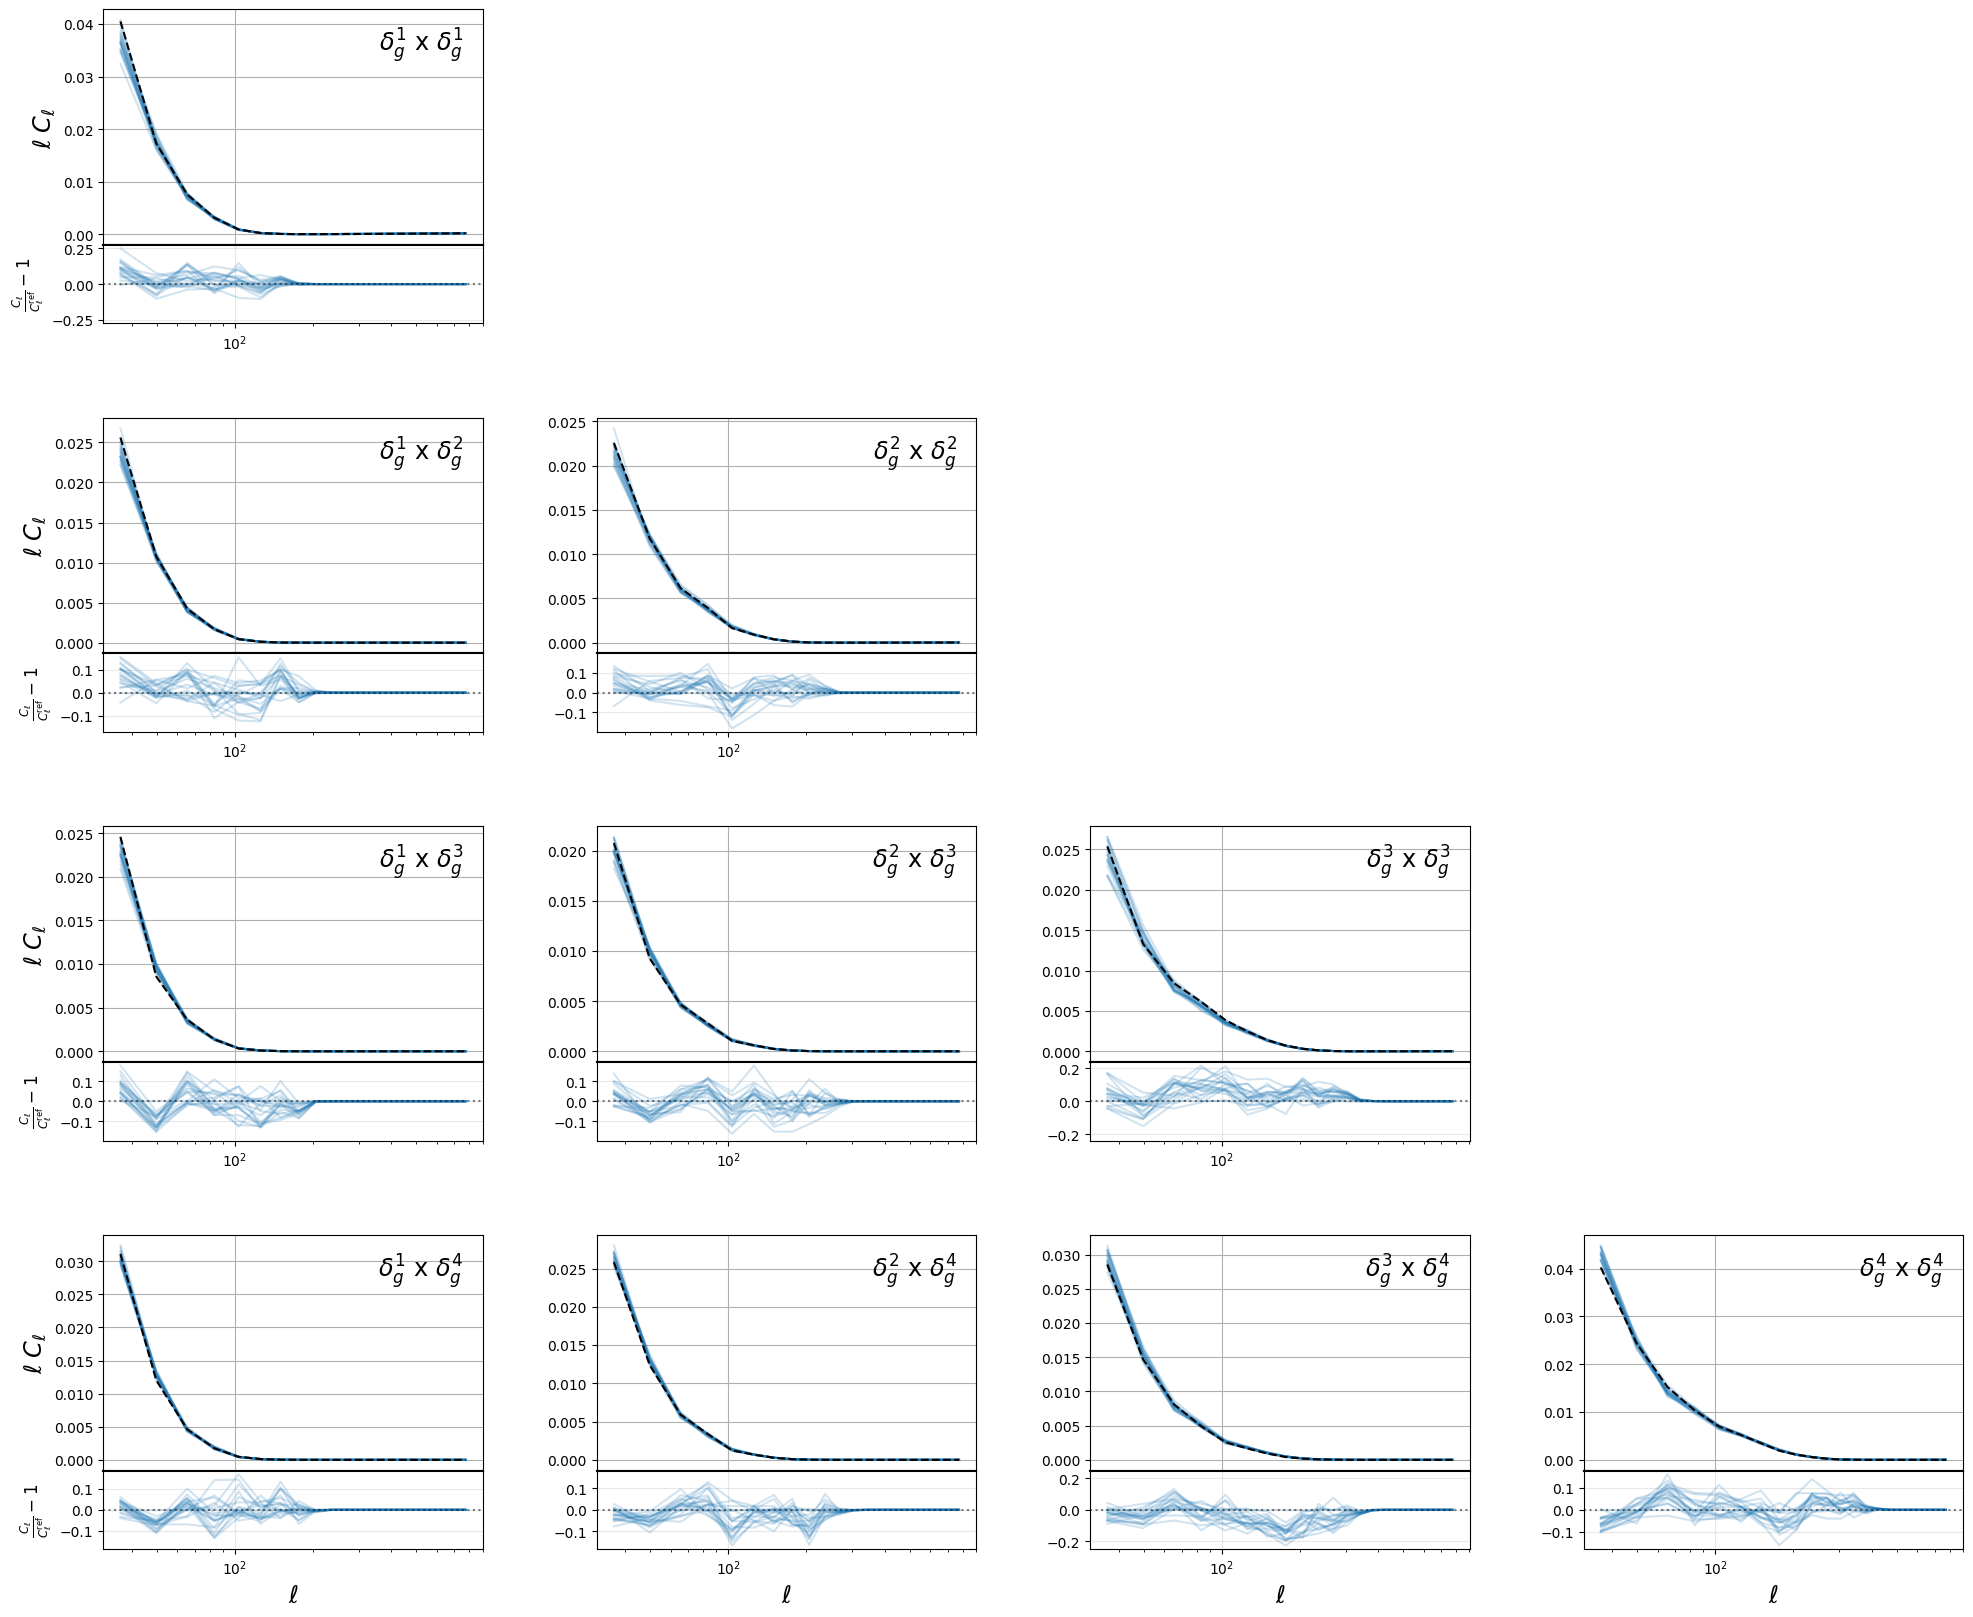

In [31]:
figsize = (24, 20)  # Increased height for residuals
fig = plt.figure(figsize=figsize)

# Create the outer gridspec - one cell per plot pair
outer_gs = fig.add_gridspec(n_z, n_z, hspace=0.3, wspace=0.3)

# Create empty 2D arrays for main axes and residual axes
ax = np.empty((n_z, n_z), dtype=object)
res_ax = np.empty((n_z, n_z), dtype=object)

# Create nested gridspecs and subplots
for i in range(n_z):
    for j in range(n_z):
        if i < j:  # Upper triangle - no plot
            continue
            
        # Create a nested gridspec for this plot pair with no internal spacing
        inner_gs = outer_gs[i, j].subgridspec(2, 1, height_ratios=[3, 1], hspace=0)
        
        # Main plot
        ax[i, j] = fig.add_subplot(inner_gs[0])
        
        # Residual plot (shares x-axis with main plot)
        res_ax[i, j] = fig.add_subplot(inner_gs[1], sharex=ax[i, j])

for k, bin_name in enumerate(bin_names):
    j, i = int(bin_name[-3]), int(bin_name[-1])
    if not with_lensing_plot and with_clustering_plot:
        i -= 4
        j -= 4
    
    if i < j:  # Skip upper triangle
        continue

    current_bins = bin_centers
    current_cosmogrid = cosmogrid_cls_reshaped[:, :, k].T
    current_buzzard = buzzard_cls_reshaped[:, k]

    current_bins = current_bins[:-10]
    current_cosmogrid = current_cosmogrid[:-10]
    current_buzzard = current_buzzard[:-10]
    
    # Plot main data
    if i == 0:
        ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=0.2, color="tab:blue", label="CosmoGrid") 
        ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--", label="Buzzard")
    else:
        ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=0.2, color="tab:blue") 
        ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--")
        
    # Plot residuals
    # residuals = (current_buzzard[:, np.newaxis] - current_cosmogrid) / (current_buzzard[:,np.newaxis] + 1e-8)
    residuals = (current_buzzard[:, np.newaxis] - current_cosmogrid) / (current_cosmogrid + 1e-8)
    # residuals = (current_buzzard[:, np.newaxis] - current_cosmogrid)
    res_ax[i,j].plot(current_bins, residuals, alpha=0.2, color="tab:blue")
    res_ax[i,j].axhline(y=0, color='k', linestyle=':', alpha=0.5)
    
    # Set residual y limits to be symmetric
    max_abs_residual = np.max(np.abs(residuals))
    res_ax[i,j].set_ylim(-max_abs_residual*1.1, max_abs_residual*1.1)
    
    # Label
    bin_i = rf"\delta_g^{i+1}"
    bin_j = rf"\delta_g^{j+1}"
    bin_label = f"${bin_j}$ x ${bin_i}$"
    ax[i, j].text(
        0.95, 0.93, bin_label,
        transform=ax[i, j].transAxes,
        fontsize='xx-large',
        ha='right', va='top'
    )

    # Cosmetics for main plot
    ax[i, j].grid(True, zorder=0)
    ax[i, j].set(xscale="log")
    
    # Hide x-axis labels for main plot
    ax[i, j].tick_params(labelbottom=False)
    
    # Ensure there's a clear dividing line between plots
    ax[i, j].spines['bottom'].set_linewidth(1.5)
    res_ax[i, j].spines['top'].set_linewidth(1.5)
    
    # Y-axis label for leftmost plots
    if j == 0:
        ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")
        res_ax[i, j].set_ylabel(r"$\frac{C_\ell}{C_\ell^\mathrm{ref}} - 1$",fontsize="large")    
    # X-axis label for bottom plots
    if i == n_z - 1:
        res_ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
    
    # Cosmetics for residual plot
    res_ax[i, j].grid(True, alpha=0.3)
    res_ax[i, j].set(xscale="log")

# Turn off upper triangle completely
for i in range(n_z):
    for j in range(i + 1, n_z):
        if hasattr(ax[i, j], 'axis'):
            ax[i, j].axis('off')
        if hasattr(res_ax[i, j], 'axis'):
            res_ax[i, j].axis('off')

# # Add legend
# handles, labels = ax[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)

fig.savefig(f"plots/cls_test_Buzzard_mean_with_residuals.png", bbox_inches="tight", dpi=100)
# fig.savefig(f"plots/cls_test_Buzzard_{i_buzzard}_with_residuals.png", bbox_inches="tight", dpi=100)

# trash